# Practice Session 9: Linear Regression

In [179]:
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import spearmanr, pearsonr, shapiro, kstest

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Yesterday, we talked about correlation, how two numerical variables tend to *move together*, and we stopped just before introducing the coefficient of determination ($R^2$).\
Today, we start with linear regression, because it naturally connects to correlation and gives us the perfect context to understand what $R^2$ actually means.\
Since the main ideas in regression are closely related to correlation, we’ll continue working with the Palmer Penguins dataset - the same one we used yesterday to visualize correlations.\
Remember how we plotted scatterplots showing, for example, the relationship between flipper length and body mass?\
We saw that between these two variables there was a **strong positive correlation** with **Pearson’s *r* = 0.871**.\
Then we played a small guessing game, trying to predict the correlation coefficients from scatterplots - and for many of the examples, some of you were surprisingly close.\
How did you manage that? Probably because, in your head, you were already trying to draw a straight line through the cloud of points - essentially doing **linear regression** mentally.

> So, before we go further, let’s quickly recall some high school mathematics. The formula for a straight line looks like this: $$y = ax + b$$
> Here, $x$ and $y$ are the two variables, $a$ is the **slope**, and $b$ is the **intercept**.  
> The intercept $b$ tells us the value of $y$ when $x = 0$.  
> The slope $a$ tells us how much $y$ changes when $x$ increases by one unit.  
> If $a > 0$, the line rises as $x$ increases; if $a < 0$, it falls.

Now that this looks familiar again, it should not be a surprise that the **regression line** is described by almost the same equation. The only difference is that we now apply it to data:
$$\hat{y}_i = \beta_1 x_i  + \beta_0 $$

Here, $x_i$ is the value of the **predictor variable** (independent variable) for observation $i$, and $\hat{y}_i$ is the **predicted value** of the **outcome variable** (dependent variable).  
> We use *hats* on $y$ to remind ourselves that these are *predictions*, not actual observations.  
> The coefficients have new symbols: $\beta_0$ is the intercept, and $\beta_1$ is the slope. That’s simply the convention used in statistics.

Of course, when we plot real data, the points never fall perfectly on the regression line. The difference between an observed value $y_i$ and its predicted value $\hat{y}_i$ is called a **residual**:
$$e_i = y_i - \hat{y}_i$$

So, putting it all together, we can write the complete linear regression model as: $$y_i = \beta_1 x_i + \beta_0 + e_i$$

> The term $e_i$ captures the part of $y_i$ that the model cannot explain - the random variation or *"noise"* around the regression line.



Now let’s redraw our scatterplot of the Palmer Penguins data - flipper length on the *x*-axis and body mass on the *y*-axis - and this time add the regression line we just defined.  

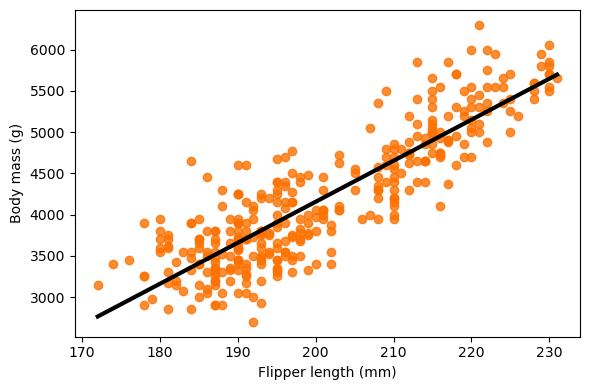

In [55]:
# Loading the Palmer Penguins dataset
penguins = sns.load_dataset('penguins')

penguins = penguins.dropna(subset=['flipper_length_mm', 'body_mass_g'])

# Creating the scatterplot with regression line
plt.figure(figsize=(6, 4))
sns.regplot(data=penguins, x='flipper_length_mm', y='body_mass_g', color='#fc7202',
            ci=None,          # no confidence interval shading
            line_kws={'color': 'black', 'lw': 3}  # regression line style
)

plt.xlabel('Flipper length (mm)')
plt.ylabel('Body mass (g)')
plt.tight_layout()
plt.show()

You’ll notice that the line runs roughly through the middle of the data points, showing the general upward trend: penguins with longer flippers tend to have higher body mass.  

To see how well this line fits, we can also draw **residuals** for each observation. These are simply the vertical distances between the observed data points and the regression line.\
When the line fits the data well, these residuals are short; when it fits poorly, they are long.  

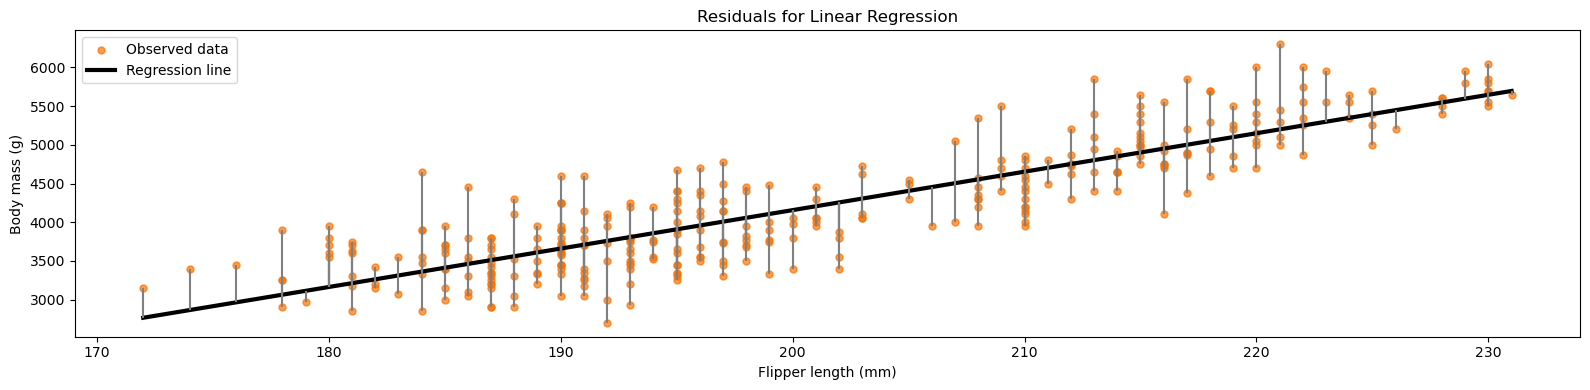

In [56]:
# Preparing data for regression
x = penguins['flipper_length_mm'].to_numpy()
y = penguins['body_mass_g'].to_numpy()

# Fitting a simple linear regression model (Ordinary Least Squares, OLS)
X = sm.add_constant(x)                      # add intercept term
model = sm.OLS(y, X).fit()
y_hat = model.predict(X)                    # predicted (fitted) values

# Sorting values by x for a smooth regression line
order = np.argsort(x)
x_sorted = x[order]
y_hat_sorted = y_hat[order]

# Creating the scatterplot with regression line and residuals
plt.figure(figsize=(16, 4))
plt.scatter(x, y, color='#fc7202', s=25, label='Observed data', alpha=0.7)
plt.plot(x_sorted, y_hat_sorted, color='black', linewidth=3, label='Regression line')

# Drawing residuals as vertical lines
plt.vlines(x, y_hat, y, color='gray', linewidth=1.5)

plt.xlabel('Flipper length (mm)')
plt.ylabel('Body mass (g)')
plt.title('Residuals for Linear Regression')
plt.legend()
plt.tight_layout()
plt.show()


So, in a well-fitting model, all those little gray segments (the residuals) are short and fairly evenly distributed above and below the regression line. This means the model captures the overall pattern of the data quite well.
In contrast, if the model fits poorly, the residuals become much longer and show a visible pattern, indicating that the line systematically misses parts of the data.

We can also visualize this idea by plotting the residuals against the fitted (predicted) values.
If the regression model is appropriate, the residuals should scatter randomly around zero, without any clear trend or structure.

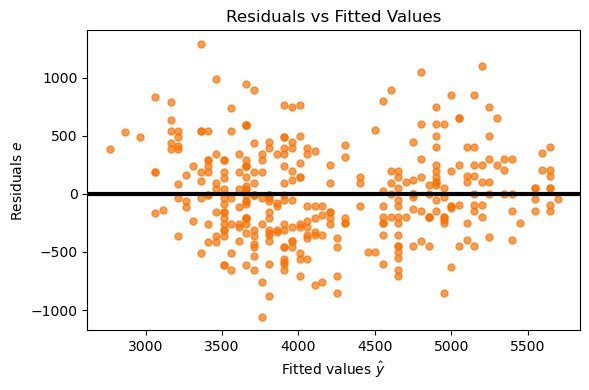

In [57]:
# Computing residuals (difference between observed and predicted values)
residuals = y - y_hat

# Creating the residuals vs fitted plot
plt.figure(figsize=(6, 4))
plt.scatter(y_hat, residuals, s=25, color='#fc7202', alpha=0.7)
plt.axhline(0, color='black', linewidth=3)       # horizontal line at zero

plt.xlabel('Fitted values $\hat{y}$')
plt.ylabel('Residuals $e$')
plt.title('Residuals vs Fitted Values')
plt.tight_layout()
plt.show()

That gives us an intuitive idea of what we want from regression: **a line that makes the residuals as small as possible**.\
Mathematically, that means we’re looking for the values of the coefficients $\beta_0$ and $\beta_1$ that minimize the total squared distance between the observed and predicted values - the **sum of squared residuals**: $$\text{minimize} \; \sum_{i=1}^{n} e_i^2$$

or, written more explicitly, $$\text{minimize} \; \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

The specific coefficient values that accomplish this are called estimates, written as $\hat{\beta}_0$ and $\hat{\beta}_1$, to indicate that they are our best guesses of the true (but unknown) population parameters.
This method of estimating regression coefficients is known as **Ordinary Least Squares (OLS)** regression.

> *Now let’s put this into practice.*\
> We’ll fit an OLS regression model for the Palmer Penguins dataset, using flipper length as the predictor and body mass as the response variable, and then take a look at the model summary to see what information it provides.

In [123]:
# Fitting OLS model: body mass as a function of flipper length
model1 = smf.ols('body_mass_g ~ flipper_length_mm', data=penguins).fit()

# Model summary
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     1071.
Date:                Fri, 17 Oct 2025   Prob (F-statistic):          4.37e-107
Time:                        01:24:06   Log-Likelihood:                -2528.4
No. Observations:                 342   AIC:                             5061.
Df Residuals:                     340   BIC:                             5069.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -5780.8314    305.81

After running the code, the OLS summary gives a lot of information at a glance. You can see the `Dep. Variable` (the outcome we modeled), the `Method` used (OLS), the `No. Observations`, as well as the `Date` and `Time` when the model was fit. We will come back to several of these fields later in more detail.

For now, focus on the middle part of the table, specifically the `coef` values for the `Intercept` and for `flipper_length_mm`. These are our estimates:
- Intercept: $-5780.8314$
- Slope for flipper length: $49.6856$

Using these, we can write the fitted regression equation: $$\hat{y} = \; 49.6856 \cdot \text{flipper\_length\_mm} -5780.8314 $$

> *Interpretation:* for each additional millimeter of flipper length, the predicted body mass increases by about $49.69$ grams on average. The intercept is the predicted body mass when flipper length is zero, which is outside the data range here, so it serves mainly as a model anchor rather than a meaningful biological value.


> *Note:* We can also access these model outputs directly in Python, without printing the full summary.\
> For example, if we want to extract the estimated coefficients, we can use:

In [124]:
# Accessing estimated coefficients
model1.params

Intercept           -5780.831358
flipper_length_mm      49.685566
dtype: float64

> This returns both the intercept and the slope values.
>
> Similarly, if you only want one of them, you can refer to it by name:

In [125]:
# Intercept
print(model1.params['Intercept'])

# Slope
print(model1.params['flipper_length_mm'])

-5780.831358077068
49.68556640610011


> And if you’re interested in just the fitted (predicted) values or residuals, you can access them as:

In [126]:
# Predicted values and residuals
print(f'Predicted values: {model1.fittedvalues}')
print(f'Residuals: {model1.resid}')

Predicted values: 0      3212.256161
1      3460.683993
2      3907.854091
4      3808.482958
5      3659.426259
          ...     
338    4851.879853
340    4901.565419
341    5249.364384
342    4752.508720
343    4802.194286
Length: 342, dtype: float64
Residuals: 0      537.743839
1      339.316007
2     -657.854091
4     -358.482958
5       -9.426259
          ...    
338     73.120147
340    -51.565419
341    500.635616
342    447.491280
343    597.805714
Length: 342, dtype: float64


> These attributes are very handy when you want to visualize or further analyze the model results (for example, to plot residuals or compare predicted and observed values).

#### Multiple Linear Regression

So far, we’ve only worked with **simple linear regression**, where there is a single predictor and one outcome variable (for example, predicting *body mass* from *flipper length* in the penguins dataset).

But in environmental science, many processes depend on **several variables at the same time**.  
For example, if we wanted to **predict chronic zinc toxicity** to the freshwater microalga *Chlorella* sp., it wouldn’t make sense to look at only one factor.  
Zinc toxicity is influenced by multiple **toxicity-modifying factors** such as **pH**, **hardness**, and **dissolved organic carbon (DOC)** (and these factors can also interact with each other).

So, instead of a simple regression, we can use a **multiple linear regression (MLR)** model to describe the relationship.  
In this case, we could write the model as: $$y_i = \beta_1 x_{1i} + \beta_2 x_{2i} + \beta_3 x_{3i} + \beta_0 + e_i$$

where:  
- $y_i$ = measured zinc toxicity for sample *i*,  
- $x_{1i}$ = pH,  
- $x_{2i}$ = hardness,  
- $x_{3i}$ = dissolved organic carbon (DOC), and  
- $e_i$ = the residual, or unexplained part of toxicity.

Each coefficient ($\beta_1$, $\beta_2$, $\beta_3$) tells us how much the toxicity changes when that variable increases by one unit, while keeping the other variables constant.  
The intercept $\beta_0$ again represents the baseline value when all predictors are zero.

Just like in simple regression, our goal is to find the set of coefficients that make the **sum of squared residuals** as small as possible: $$\text{minimize} \; \sum_{i=1}^{n} e_i^2$$

The equation above shows what a multiple regression model looks like when we include **three predictors**.  
If we wanted to include even more predictors, the idea would stay exactly the same - we would just keep adding more terms, one for each new variable, and each with its own coefficient.

In general, if our model includes $k$ predictor variables, the multiple regression equation can be written as: $$y_i = \beta_1 x_{1i} + \beta_2 x_{2i} + \beta_3 x_{3i} + \dots + \beta_k x_{ki} + \beta_0 + e_i$$

Here, each $\beta_j$ (for $j = 1, 2, \dots, k$) is the estimated **coefficient** for the $j$-th predictor variable, indicating how it contributes to the outcome.  
The residual term $e_i$ represents the portion of observation $i$ that the model does not explain.




#### <font color="#fc7202">Task 1:</font>

Use the Palmer Penguins dataset and focus on Gentoo penguins. Your goal is to build and evaluate linear regression models that predict body mass.

**Part A. Simple linear regression with one numeric predictor**

For this first part, **use only** `flipper_length_mm` as the predictor.

1. **Subset the data** to Gentoo penguins.  
2. **Fit the model** `body_mass_g ~ flipper_length_mm`.  
3. **Report the coefficients** and write the **fitted regression equation** with your estimated numbers:  
   $$\hat{y} = \hat{\beta}_1 \cdot \text{flipper\_length\_mm} + \hat{\beta}_0$$
   where $\hat{y}$ is the predicted body mass in grams.  
4. **Briefly interpret** the slope in context.

In [127]:
# Load and subset
gentoo = penguins.query('species == "Gentoo"')

# Fit OLS
model_gentoo1 = smf.ols('body_mass_g ~ flipper_length_mm', data=gentoo).fit()
print(model_gentoo1.summary())

# Coefficients and equation
b0 = model_gentoo1.params['Intercept']
b1 = model_gentoo1.params['flipper_length_mm']
print(f'Equation: ŷ = {b1:.4f} · flipper_length_mm + ({b0:.4f})')
print(f'Interpretation: for each +1 mm flipper length, predicted body mass changes by {b1:.2f} g.')

                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     118.0
Date:                Fri, 17 Oct 2025   Prob (F-statistic):           1.33e-19
Time:                        01:24:43   Log-Likelihood:                -897.57
No. Observations:                 123   AIC:                             1799.
Df Residuals:                     121   BIC:                             1805.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -6787.2806   1092.55

**Part B. Residual analysis: residuals vs fitted values (with LOWESS)**

1. Compute residuals and fitted values.
2. Plot residuals vs fitted values and add a horizontal line at 0.
3. Add a `LOWESS` line to the plot to check for any patterns or non-linearity.
> In Python, you can add a `LOWESS` curve using `sm.nonparametric.lowess(residuals, fitted_values, frac=...)`.\
> This function performs **Locally Weighted Scatterplot Smoothing** - it fits many small local regressions along the *x*-axis and returns a smooth curve that you can plot on top of your residuals.\
> The argument `frac` controls how smooth the line is (larger values make the curve smoother, smaller values make it follow the data more closely).\
> If the `LOWESS` line stays roughly flat around zero, the linear model fits well.\
> If it bends or shows a visible trend, there may be a non-linear pattern that the model doesn’t capture.

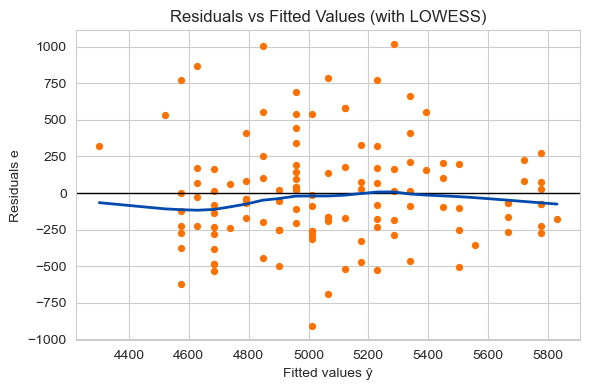

In [193]:
fitted = model_gentoo1.fittedvalues
residuals = model_gentoo1.resid

plt.figure(figsize=(6, 4))
plt.scatter(fitted, residuals, s=18, color='#fc7202')
plt.axhline(0, color='black', linewidth=1)

# LOWESS smooth; frac controls how much data each local fit uses (0 to 1)
lowess = sm.nonparametric.lowess(residuals, fitted, frac=0.6)
plt.plot(lowess[:, 0], lowess[:, 1], color='#004aad', linewidth=2)

plt.xlabel('Fitted values ŷ')
plt.ylabel('Residuals e')
plt.title('Residuals vs Fitted Values (with LOWESS)')
plt.tight_layout()
plt.show()

**Part C. Residual normality check**

Make a Q-Q plot to assess whether residuals are approximately normally distributed.

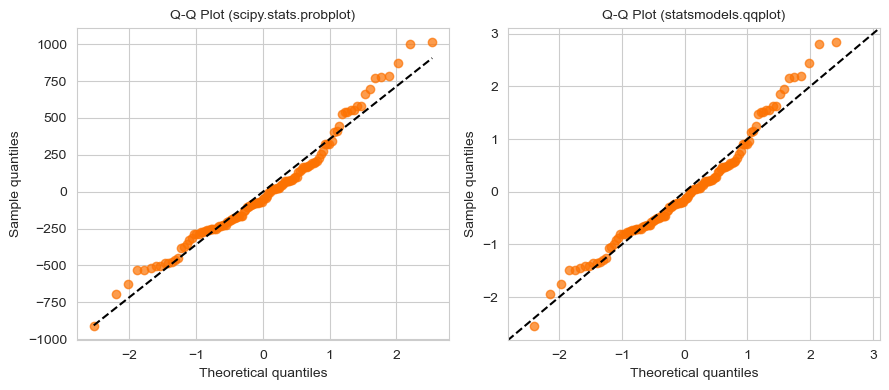

In [129]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Left: Q-Q plot using scipy.stats.probplot
ax = axes[0]
res = stats.probplot(residuals, dist='norm', plot=ax)
ax.get_lines()[0].set_markerfacecolor('#fc7202')
ax.get_lines()[0].set_markeredgecolor('#fc7202')
ax.get_lines()[0].set_alpha(0.7)

ax.get_lines()[1].set_color('black')
ax.get_lines()[1].set_linestyle('--')

ax.set_title('Q-Q Plot (scipy.stats.probplot)', fontsize=10)
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Sample quantiles')

# Right: Q-Q plot using statsmodels.api.qqplot
ax = axes[1]
sm.qqplot(residuals, line='45', fit=True, ax=ax,
          markerfacecolor='#fc7202', markeredgecolor='#fc7202', alpha=0.7)

ax.get_lines()[1].set_color('black')
ax.get_lines()[1].set_linestyle('--')

ax.set_title('Q-Q Plot (statsmodels.qqplot)', fontsize=10)
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Sample quantiles')

plt.tight_layout()
plt.show()

> *Note:* So far, we’ve been using `scipy.stats.probplot()` to create Q-Q plots.
> However, `statsmodels.api.qqplot()` is an alternative that provides similar functionality.
> Both functions compare the quantiles of your residuals against a theoretical normal distribution - if all the points fall close to the dashed 45° line, the residuals are approximately normally distributed.

> In a well-fitted linear regression model, we generally expect the residuals to follow a normal distribution.
> This assumption comes from the idea that the model has already captured all systematic patterns in the data, so what remains (the residuals) should just be random noise.
>
> If the model is correct and the sources of random error are additive and independent, then by the **Central Limit Theorem**, these residuals should be approximately normally distributed.
>
> Normally distributed residuals ensure that many of our statistical tests (like *t*-tests for coefficients or *F*-tests for overall significance) are valid and that confidence intervals behave as expected.

**Part D. Extend beyond one predictor**

Now that you have the simple model with `flipper_length_mm`, extend the analysis by adding `bill_length_mm` as a second predictor.

1. Fit the multiple linear regression for Gentoo: `body_mass_g ~ flipper_length_mm + bill_length_mm`.  
2. Inspect the summary and note which predictors are important.  
3. Write the multiple regression equation with your estimated coefficients.  
4. Repeat the analysis: residuals vs fitted values with **LOWESS**, and a **Q-Q plot** for residual normality.


In [131]:
# MLR with flipper_length_mm + bill_length_mm
mlr_gentoo = smf.ols('body_mass_g ~ flipper_length_mm + bill_length_mm', data=gentoo).fit()
print(mlr.summary())

# Coefficients and equation
b0 = mlr_gentoo.params['Intercept']
b_flipper = mlr_gentoo.params['flipper_length_mm']
b_billlen = mlr_gentoo.params['bill_length_mm']
print(f'Equation: ŷ = {b_flipper:.4f} · flipper_length_mm + {b_billlen:.4f} · bill_length_mm + ({b0:.4f})')

                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     78.92
Date:                Fri, 17 Oct 2025   Prob (F-statistic):           1.33e-22
Time:                        01:25:30   Log-Likelihood:                -887.80
No. Observations:                 123   AIC:                             1782.
Df Residuals:                     120   BIC:                             1790.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -5554.3822   1048.99

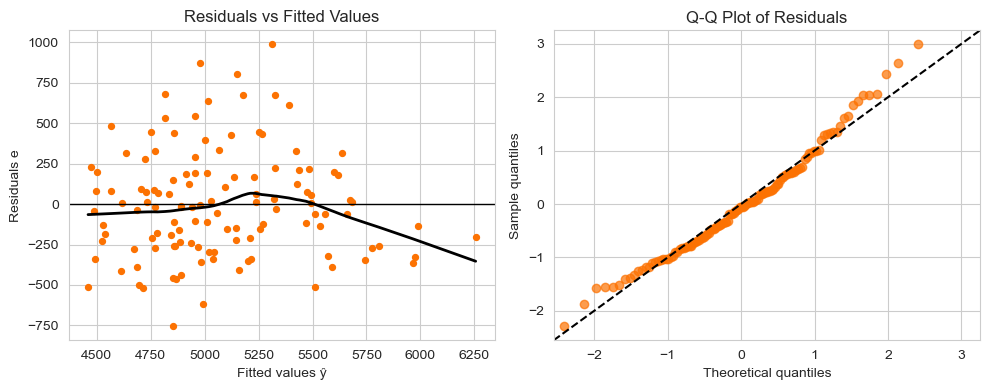

In [132]:
fitted = mlr_gentoo.fittedvalues
residuals = mlr_gentoo.resid

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Residuals vs Fitted Values
ax = axes[0]
ax.scatter(fitted, residuals, s=18, color='#fc7202')
ax.axhline(0, color='black', linewidth=1)

# LOWESS smooth (frac controls smoothness)
lowess = sm.nonparametric.lowess(residuals, fitted, frac=0.6)
ax.plot(lowess[:, 0], lowess[:, 1], color='black', linewidth=2)

ax.set_xlabel('Fitted values ŷ')
ax.set_ylabel('Residuals e')
ax.set_title('Residuals vs Fitted Values')

# Q-Q plot
ax = axes[1]
sm.qqplot(residuals, line='45', fit=True, ax=ax,
          markerfacecolor='#fc7202', markeredgecolor='#fc7202', alpha=0.7)

# customize the 45° line
ax.get_lines()[1].set_color('black')
ax.get_lines()[1].set_linestyle('--')

ax.set_title('Q-Q Plot of Residuals')
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Sample quantiles')

plt.tight_layout()
plt.show()

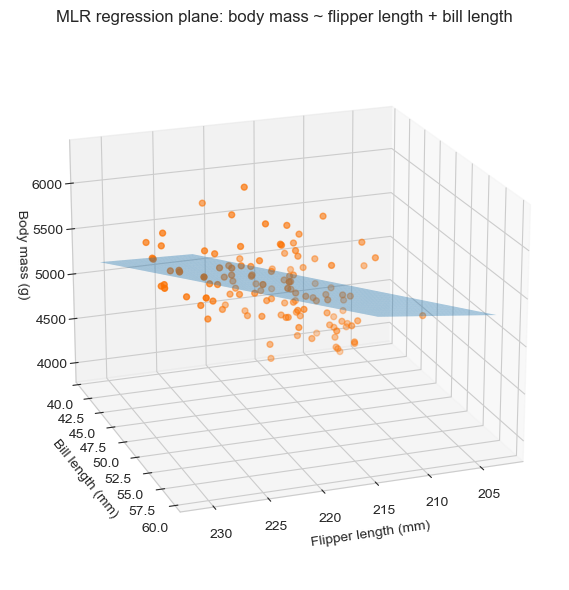

In [195]:
# Coefficients
b0 = mlr_gentoo.params['Intercept']
b_flipper = mlr_gentoo.params['flipper_length_mm']
b_bill = mlr_gentoo.params['bill_length_mm']

# Predictor ranges for a smooth plane
fx = np.linspace(gentoo['flipper_length_mm'].min(), gentoo['flipper_length_mm'].max(), 35)
bx = np.linspace(gentoo['bill_length_mm'].min(), gentoo['bill_length_mm'].max(), 35)
FX, BX = np.meshgrid(fx, bx)

# Predicted body mass on the grid (the regression plane)
Zhat = b0 + b_flipper * FX + b_bill * BX

# 3D plot: X = flipper length, Y = bill length, Z = predicted body mass
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plane
ax.plot_surface(FX, BX, Zhat, alpha=0.4, linewidth=0, antialiased=True)

# Observed points
ax.scatter(
    gentoo['flipper_length_mm'],
    gentoo['bill_length_mm'],
    gentoo['body_mass_g'],
    color='#fc7202',
    s=18,
    depthshade=True
)

# Labels and view
ax.set_xlabel('Flipper length (mm)')
ax.set_ylabel('Bill length (mm)')
ax.set_zlabel('Body mass (g)')
ax.set_title('MLR regression plane: body mass ~ flipper length + bill length')
ax.view_init(elev=20, azim=70)

plt.tight_layout()
plt.show()

#### Coefficient of Determination (R²)

Now that we’ve explored what linear models are and how we fit them, we can finally return to where we stopped yesterday - the **coefficient of determination**, usually written as **R²**.

So far, we’ve used the **correlation coefficient (r)** to describe the *strength and direction* of a linear relationship between two variables.  
However, we can also express this relationship in terms of how much **variation** in one variable is *explained* by the other - and that’s exactly what R² tells us.

**What is R²?**

R² measures **how well our regression model fits the data**.  
It tells us the **proportion of the total variability** in the outcome (dependent variable) that can be explained by the predictor(s) in the model.

If the predicted values ($\hat{y}_i$) are very close to the observed values ($y_i$), then our model fits well, and R² will be close to 1.  
If the predictions are far off, R² will be close to 0.

Formally, for a regression model $\hat{y}_i = \beta_1 x_i  + \beta_0$, the total variation in $y$ can be separated into two parts:

- **Explained (model) variation:** how much of the total variability in $y$ is captured by the regression line  
- **Unexplained (residual) variation:** how much variability remains around that line  

We can quantify this using **sums of squares**: $SS_\text{total} = SS_\text{regression} + SS_\text{residual}$

where:
- $SS_\text{total} = \sum_i (y_i - \bar{y})^2$ 
- $SS_\text{regression} = \sum_i (\hat{y}_i - \bar{y})^2$
- $SS_\text{residual} = \sum_i (y_i - \hat{y}_i)^2$

We define R² as the **proportion of the total variation explained** by the model: $$R^2 = \frac{SS_\text{regression}}{SS_\text{total}}$$

Since $SS_\text{residual} = SS_\text{total} - SS_\text{regression}$, we can also write: $$R^2 = 1 - \frac{SS_\text{residual}}{SS_\text{total}}$$

This form makes the intuition clear:  **the smaller the residuals → the larger the R² → the better the model fits**.

> **Computing R² manually**
>
> We can easily check this with the **first model we fitted today** - the simple linear regression that predicts **body mass** from **flipper length** using **all penguins**.




In [136]:
Y = penguins['body_mass_g']
Y_pred = model1.fittedvalues

SS_resid = np.sum((Y - Y_pred)**2)
SS_tot = np.sum((Y - np.mean(Y))**2)
R2_manual = 1 - (SS_resid / SS_tot)

print(f'Calculated R²: {R2_manual:.4f}')
print(f'Statsmodels R²: {model1.rsquared:.4f}')

Calculated R²: 0.7590
Statsmodels R²: 0.7590


**Interpreting R²**

R² ranges between **0** and **1**:
- **R² = 1.0** → a *perfect fit*: all variation in the outcome ($y$) is explained by the model (almost never happens in real data).  
- **R² = 0.0** → a *useless model*: it explains none of the variation and performs no better than simply predicting the mean.

For our simple regression model predicting **body mass from flipper length** (using all penguins), **R² = 0.759** - meaning that about **75.9% of the variation in body mass** can be explained by differences in **flipper length**.  
The remaining **24.1%** represents unexplained variability - individual differences, measurement noise, or other biological factors not captured by this single predictor.



**Connection to correlation (simple regression)**

When we have only one predictor, R² is directly linked to the Pearson correlation coefficient (*r*): $R^2 = r_{xy}^2$\
That is, R² is literally the square of the correlation between the predictor and the outcome.\
You can verify this:

In [137]:
r = penguins['body_mass_g'].corr(penguins['flipper_length_mm'])
print(f'Correlation (r): {r:.4f},  R² = {r**2:.4f}')


Correlation (r): 0.8712,  R² = 0.7590


> The result matches the R² value reported in the simple regression summary.

**Adjusted R²**

In multiple regression, adding more predictors will **always** increase (or at least not decrease) the R² value - even if the new variables add little real explanatory power.  
To correct for this, we use the **adjusted R²**, which introduces a penalty for unnecessary predictors.

The formula is: $$R^2_\text{adj} = 1 - (1 - R^2)\frac{n - 1}{n - p - 1}$$

where:  
- $n$ = number of observations  
- $p$ = number of predictors (excluding the intercept)

This adjustment takes into account the model’s **degrees of freedom**. As a result, adjusted R² will only increase if the new predictors improve the model more than would be expected by chance.

> To confirm this, we can use the fitted MLR model from Task 1 (`mlr_gentoo`) to compute the adjusted R² manually from the formula and compare it with the value reported by `statsmodels`.




In [138]:
# Pull values from the fitted model
R2 = mlr_gentoo.rsquared
n  = int(mlr_gentoo.nobs)          # number of observations
p  = int(mlr_gentoo.df_model)      # number of predictors (excludes the intercept)

# Manual adjusted R²
R2_adj_manual = 1 - (1 - R2) * ((n - 1) / (n - p - 1))

print(f'R² (model):          {R2:.6f}')
print(f'Adjusted R² (manual): {R2_adj_manual:.6f}')
print(f'Adjusted R² (model):  {mlr_gentoo.rsquared_adj:.6f}')

R² (model):          0.568104
Adjusted R² (manual): 0.560906
Adjusted R² (model):  0.560906


In [139]:
mlr_gentoo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            body_mass_g   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     78.92
Date:                Fri, 17 Oct 2025   Prob (F-statistic):           1.33e-22
Time:                        01:44:06   Log-Likelihood:                -887.80
No. Observations:                 123   AIC:                             1782.
Df Residuals:                     120   BIC:                             1790.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -5554.3822   1048.993     -5.295      0.000   -7631.316   -3477.449
flipper_length_mm    35.9411      6.216      5.782      0.000      23.634      48.249
bill_length_mm       59.4563     13.080      4.546      0.000      33.558      85.354
==============================================================================
Omnibus:                        6.285   Durbin-Watson:                   2.322
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                6.049
Skew:                           0.540   Prob(JB):                       0.0486
Kurtosis:                       3.126   Cond. No.                     7.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### <font color="#fc7202">Task 2:</font>

Yesterday, in **Task 6**, you worked with the dataset `animals.tsv`.  
Now, you will use the same dataset to explore how well **body weight** predicts **brain weight** using a simple linear regression model.

1. **Fit a simple linear regression model** with `brain_weight` as the outcome and `body_weight` as the predictor.  
2. **Compute the coefficient of determination (R²)** to evaluate how much of the variation in brain weight is explained by body weight.  
3. **Interpret the R² value** 
4. **Inspect the residuals** (e.g., using a residual plot and Q-Q plot) to assess whether the model fits the data reasonably well.


> Based on yesterday’s practice session, we observed that the data was not normally distributed.\
> However, after applying a log transformation, it appeared to follow a roughly normal distribution.\
> Therefore, let's begin by log-transforming our data again.

In [203]:
animals = pd.read_csv('animals.tsv', sep='\t')
# Creating a new column 'classification' by assigning each animal to a category: replacing specific names with 'Dinosaur' or 'Human', and labeling all others as 'Mammal'
animals['classification'] = (animals['Animal'].replace({'Brachiosaurus': 'Dinosaur', 'Dipliodocus': 'Dinosaur', 'Triceratops': 'Dinosaur', 'Human': 'Human'}).apply(lambda x: x if x in ['Human', 'Dinosaur'] else 'Mammal'))
# Creating log-transformed variables
animals['log_body'] = np.log(animals['body'])
animals['log_brain'] = np.log(animals['brain'])
animals.head()

,Animal,body,brain,classification,log_body,log_brain
0,Mountain beaver,1.35,8.1,Mammal,0.300105,2.091864
1,Cow,465.00,423.0,Mammal,6.142037,6.047372
2,Grey wolf,36.33,119.5,Mammal,3.592644,4.783316
3,Goat,27.66,115.0,Mammal,3.319987,4.744932
4,Guinea pig,1.04,5.5,Mammal,0.039221,1.704748


In [204]:
# Fitting OLS model
model_animals = smf.ols('log_brain ~ log_body', data=animals).fit()

# Model summary
print(model_animals.summary())

                            OLS Regression Results                            
Dep. Variable:              log_brain   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     40.26
Date:                Fri, 17 Oct 2025   Prob (F-statistic):           1.02e-06
Time:                        11:09:02   Log-Likelihood:                -50.629
No. Observations:                  28   AIC:                             105.3
Df Residuals:                      26   BIC:                             107.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5549      0.413      6.184      0.0

> The R² value of 0.608 indicates that approximately 61% of the variation in brain weight can be explained by body weight.\
> This suggests a moderately strong linear relationship between the two variables, meaning body weight is a reasonably good predictor of brain weight, though other factors likely also play a role.
>
> Next, we will perform a residual analysis to evaluate the model fit.

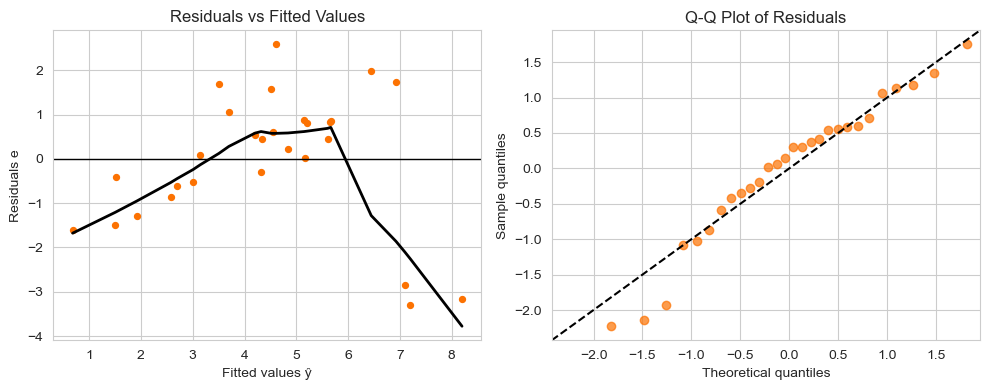

In [202]:
fitted = model_animals.fittedvalues
residuals = model_animals.resid

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Residuals vs Fitted Values
ax = axes[0]
ax.scatter(fitted, residuals, s=18, color='#fc7202')
ax.axhline(0, color='black', linewidth=1)

# LOWESS smooth (frac controls smoothness)
lowess = sm.nonparametric.lowess(residuals, fitted, frac=0.6)
ax.plot(lowess[:, 0], lowess[:, 1], color='black', linewidth=2)

ax.set_xlabel('Fitted values ŷ')
ax.set_ylabel('Residuals e')
ax.set_title('Residuals vs Fitted Values')

# Q-Q plot
ax = axes[1]
sm.qqplot(residuals, line='45', fit=True, ax=ax,
          markerfacecolor='#fc7202', markeredgecolor='#fc7202', alpha=0.7)

# customize the 45° line
ax.get_lines()[1].set_color('black')
ax.get_lines()[1].set_linestyle('--')

ax.set_title('Q-Q Plot of Residuals')
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Sample quantiles')

plt.tight_layout()
plt.show()

> Based on the plots, we can see that there are three data points that deviate substantially from the rest.\
> Let's recall that our dataset also includes three dinosaurs. We already observed yesterday that when we excluded them, the correlation coefficient increased noticeably.\
> Therefore, let's remove these points from our model, refit the regression, and perform the analysis again.

In [211]:
# Fitting the OLS model again after excluding the dinosaurs
model_animals_without_dino = smf.ols('log_brain ~ log_body', data=animals[animals.classification != 'Dinosaur']).fit()

# Model summary
print(model_animals_without_dino.summary())

                            OLS Regression Results                            
Dep. Variable:              log_brain   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     270.7
Date:                Fri, 17 Oct 2025   Prob (F-statistic):           3.24e-14
Time:                        12:49:20   Log-Likelihood:                -26.421
No. Observations:                  25   AIC:                             56.84
Df Residuals:                      23   BIC:                             59.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1504      0.201     10.720      0.0

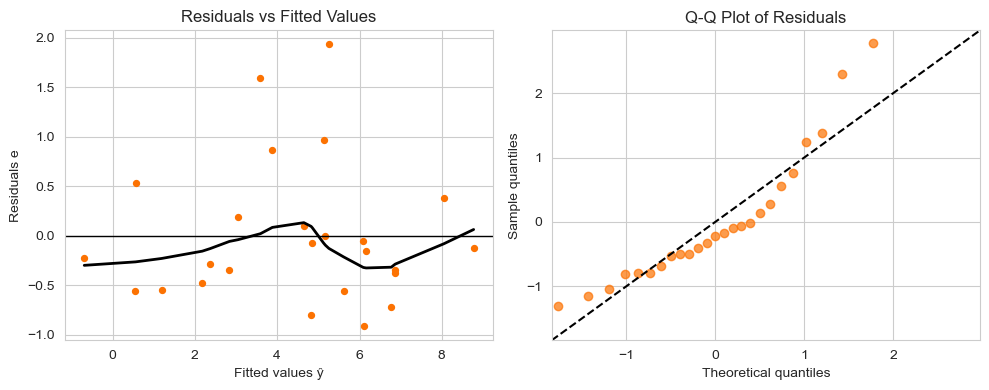

In [212]:
fitted = model_animals_without_dino.fittedvalues
residuals = model_animals_without_dino.resid

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Residuals vs Fitted Values
ax = axes[0]
ax.scatter(fitted, residuals, s=18, color='#fc7202')
ax.axhline(0, color='black', linewidth=1)

# LOWESS smooth (frac controls smoothness)
lowess = sm.nonparametric.lowess(residuals, fitted, frac=0.6)
ax.plot(lowess[:, 0], lowess[:, 1], color='black', linewidth=2)

ax.set_xlabel('Fitted values ŷ')
ax.set_ylabel('Residuals e')
ax.set_title('Residuals vs Fitted Values')

# Q-Q plot
ax = axes[1]
sm.qqplot(residuals, line='45', fit=True, ax=ax,
          markerfacecolor='#fc7202', markeredgecolor='#fc7202', alpha=0.7)

# customize the 45° line
ax.get_lines()[1].set_color('black')
ax.get_lines()[1].set_linestyle('--')

ax.set_title('Q-Q Plot of Residuals')
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Sample quantiles')

plt.tight_layout()
plt.show()

> The R² value is now 0.922, which is substantially higher than before.\
> This means that body weight now explains about 92% of the variation in brain weight, indicating a much stronger linear relationship.\
> In addition, the residuals appear more normally distributed, suggesting that the model fits the data better after removing the dinosaur observations.

#### Hypothesis Tests for Regression Models

So far, we have learned how to build linear regression models, estimate their coefficients, and assess their performance using **R²**.  
Now we turn to an equally important question - how to test whether the model, or its individual predictors, are **statistically significant**.

There are two main hypothesis tests we can perform:

1. **Testing the model as a whole:**  
   Does our regression model explain a significant amount of variation in the outcome compared to a null model (with no predictors)?

2. **Testing individual coefficients:**  
   Is a specific predictor variable (e.g., flipper length) significantly related to the outcome (e.g., body mass)?


##### Testing the model as a whole - the *F*-test

Let’s start by testing whether the **entire regression model** provides a better fit than a model that includes only the intercept.  
Formally, the hypotheses are:

- **Null hypothesis ($H_0$):** All slope coefficients are 0 (no relationship between predictors and the outcome).  
- **Alternative hypothesis ($H_1$):** At least one slope coefficient differs from 0.

This is assessed using the ***F*-statistic**, which compares how much variance the model explains relative to how much remains unexplained.  
(Just as in ANOVA), the total variation can be divided into two parts: $SS_\text{total} = SS_\text{regression} + SS_\text{residual}$

We then compute **mean squares** and form the ratio: $$F = \frac{MS_\text{regression}}{MS_\text{residual}}$$

A large *F*-value (with a small *p*-value) indicates that the model explains a significant portion of the variance in the outcome.



> **Example: Does flipper length explain body mass?**\
> Let’s test whether a simple linear regression model using **flipper length** as the predictor significantly explains variation in **body mass** across all penguins.


In [140]:
Y = penguins['body_mass_g']
Y_pred = model1.fittedvalues
residuals = model1.resid

# Calculate sums of squares
SS_res = np.sum(residuals**2)
SS_tot = np.sum((Y - np.mean(Y))**2)
SS_reg = SS_tot - SS_res

# Degrees of freedom
df_model = int(model1.df_model)      # number of predictors
df_resid = int(model1.df_resid)      # residual degrees of freedom

# Mean squares
MS_model = SS_reg / df_model
MS_resid = SS_res / df_resid

# F-statistic and p-value
F = MS_model / MS_resid
p_value = stats.f.sf(F, df_model, df_resid)

print(f'F = {F:.2f}, p = {p_value:.3e}')

F = 1070.74, p = 4.371e-107


We could actually obtain the same ***F*-statistic** and *p*-value directly from the model summary table:

In [141]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            body_mass_g   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     1071.
Date:                Fri, 17 Oct 2025   Prob (F-statistic):          4.37e-107
Time:                        01:55:40   Log-Likelihood:                -2528.4
No. Observations:                 342   AIC:                             5061.
Df Residuals:                     340   BIC:                             5069.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -5780.8314    305.815    -18.903      0.000   -6382.358   -5179.305
flipper_length_mm    49.6856      1.518     32.722      0.000      46.699      52.672
==============================================================================
Omnibus:                        5.634   Durbin-Watson:                   2.176
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                5.585
Skew:                           0.313   Prob(JB):                       0.0613
Kurtosis:                       3.019   Cond. No.                     2.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

> Based on these results we can say that the overall model is **highly significant** (*F*(1, 340) = 1071, *p* < 0.001), indicating that flipper length explains a substantial portion of the variation in penguin body mass.

##### Testing individual coefficients - the *t*-test

The *F*-test tells us that the **model as a whole** explains a significant portion of the variation in the data, but it does not tell us **which predictors** are actually contributing to that relationship.  
To evaluate each predictor individually, we use a ***t*-test** for each regression coefficient.

For each predictor $x_j$, the hypotheses are:

- **Null hypothesis ($H_0$):** $\beta_j = 0$ → the predictor has no effect on the outcome.  
- **Alternative hypothesis ($H_1$):** $\beta_j \neq 0$ → the predictor has a significant effect.

The test statistic is defined as: $$t = \frac{\hat{\beta}_j}{SE(\hat{\beta}_j)}$$

where $\hat{\beta}_j$ is the estimated coefficient and $SE(\hat{\beta}_j)$ is its standard error.  
The resulting *t*-value is compared against the *t*-distribution with $(n - p - 1)$ degrees of freedom to obtain a *p*-value.

> In Python, these values appear directly in the regression summary table:

In [144]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            body_mass_g   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     1071.
Date:                Fri, 17 Oct 2025   Prob (F-statistic):          4.37e-107
Time:                        02:03:36   Log-Likelihood:                -2528.4
No. Observations:                 342   AIC:                             5061.
Df Residuals:                     340   BIC:                             5069.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -5780.8314    305.815    -18.903      0.000   -6382.358   -5179.305
flipper_length_mm    49.6856      1.518     32.722      0.000      46.699      52.672
==============================================================================
Omnibus:                        5.634   Durbin-Watson:                   2.176
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                5.585
Skew:                           0.313   Prob(JB):                       0.0613
Kurtosis:                       3.019   Cond. No.                     2.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For our simple regression model predicting body mass from flipper length, we see:

| Variable            |   Coef.   | Std Err |    t    | P>\|t\| |  [0.025  |  0.975] |
|----------------------|-----------|---------|---------|---------|----------|----------|
| Intercept            | -5780.83  | 305.82  | -18.90  | 0.000   | -6382.36 | -5179.31 |
| flipper_length_mm    |   49.69   |   1.52  |  32.72  | 0.000   |   46.70  |   52.67  |

- The *t*-statistic tests whether each coefficient differs significantly from zero.
- The *p*-value (*P*>|*t*|) tells us whether that difference is statistically significant.
- A *p*-value below 0.05 indicates that the predictor has a meaningful linear relationship with the outcome.

> Flipper length shows a *p*-value well below 0.05, indicating a highly significant effect.
> In other words, flipper length is a strong predictor of body mass - penguins with longer flippers generally weigh more.



#### <font color="#fc7202">Task 3:</font>

<div style="display: flex; align-items: center; justify-content: space-between;">

<div style="flex: 1;">

You are given a file `toxicity.tsv` containing measurements for chemicals:
- **Octanol/Water partition coefficient** (`Kow`, a measure of hydrophobicity)
- **LC50** for fathead minnows — the concentration (in **mmol/L**) that causes 50% mortality.


**Part A. Explore and visualize**

1. **Load** the dataset and inspect basic summaries (e.g., number of rows, missing values, variable ranges).  
2. **Visualize** the relationship between `Kow` and `LC50` with a **scatterplot**, and then explore the individual distributions of both variables using **histograms**.

</div>

<div style="flex: 0.5 0 400px; margin-left: 40px;">
<img src="https://raw.githubusercontent.com/RaHub4AI/MI7032/refs/heads/main/Pictures/lethal_concentration.png"
     alt="Curious cow"
     width="400"
     style="border-radius: 10px;">
</div>

</div>


In [158]:
toxicity = pd.read_csv('toxicity.tsv', sep='\t')

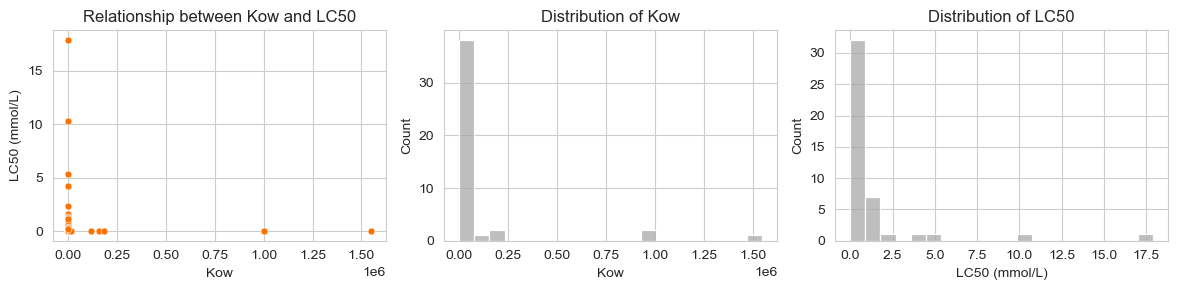

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Scatterplot
sns.scatterplot(data=toxicity, x='Kow', y='LC50 (mmol/L)', s=25, color='#fc7202', ax=axes[0])
axes[0].set_xlabel('Kow')
axes[0].set_ylabel('LC50 (mmol/L)')
axes[0].set_title('Relationship between Kow and LC50')

# Histograms
sns.histplot(toxicity['Kow'], bins=20, color='darkgray', ax=axes[1])
axes[1].set_xlabel('Kow')
axes[1].set_title('Distribution of Kow')

sns.histplot(toxicity['LC50 (mmol/L)'], bins=20, color='darkgray', ax=axes[2])
axes[2].set_xlabel('LC50 (mmol/L)')
axes[2].set_title('Distribution of LC50')

plt.tight_layout()
plt.show()

**Part B. Normality checks (assumptions)**

Before fitting a regression or correlation model, it’s important to check whether the data follow a **normal distribution**.  
Use **Q-Q plots** to visually assess the normality of both variables (`Kow` and `LC50`).  
If one or both variables are clearly **non-normally distributed**, apply a transformation (for example, a $\text{log}_{10}$ transformation) and check again whether the transformed data better follow a normal distribution.

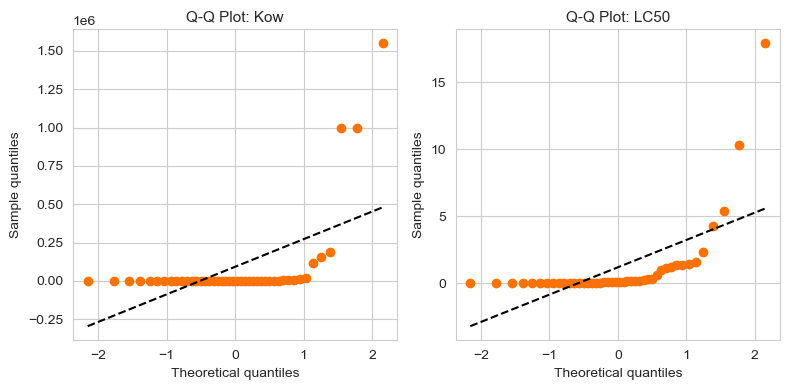

In [171]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Q-Q plot for Kow
res1 = stats.probplot(toxicity['Kow'], dist='norm', plot=axes[0])
axes[0].get_lines()[0].set_markerfacecolor('#fc7202')
axes[0].get_lines()[0].set_markeredgecolor('#fc7202')
axes[0].get_lines()[1].set_color('black')
axes[0].get_lines()[1].set_linestyle('--')
axes[0].set_title('Q-Q Plot: Kow', fontsize=11)
axes[0].set_xlabel('Theoretical quantiles')
axes[0].set_ylabel('Sample quantiles')

# Q-Q plot for LC50
res2 = stats.probplot(toxicity['LC50 (mmol/L)'], dist='norm', plot=axes[1])
axes[1].get_lines()[0].set_markerfacecolor('#fc7202')
axes[1].get_lines()[0].set_markeredgecolor('#fc7202')
axes[1].get_lines()[1].set_color('black')
axes[1].get_lines()[1].set_linestyle('--')
axes[1].set_title('Q-Q Plot: LC50', fontsize=11)
axes[1].set_xlabel('Theoretical quantiles')
axes[1].set_ylabel('Sample quantiles')

plt.tight_layout()
plt.show()

> From the Q-Q plots, we can clearly see that the data are **not normally distributed** - both `Kow` and `LC50` show strong deviations from the diagonal line.  
> Since we know that **concentration-type variables** often span several orders of magnitude and are typically **right-skewed**, a **log transformation** is a natural next step to stabilize variance and make the data more normally distributed.
>
> Let’s apply a $\text{log}_{10}$ transformation and re-check the distributions:

In [ ]:
toxicity['log_Kow'] = np.log10(toxicity['Kow'])
toxicity['log_LC50'] = np.log10(toxicity['LC50 (mmol/L)'])

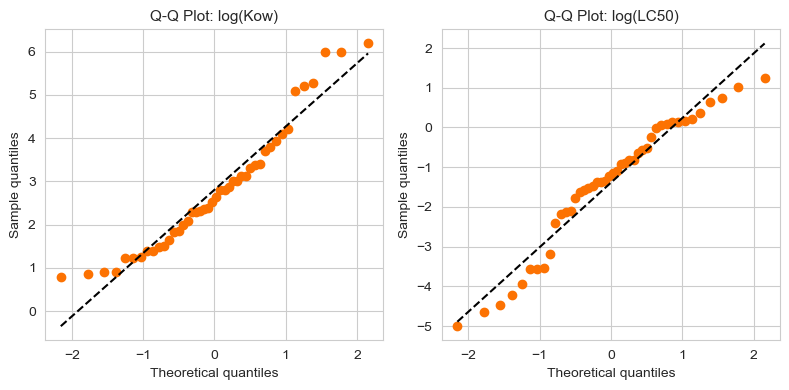

In [174]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Q-Q plot for log(Kow)
res1 = stats.probplot(toxicity['log_Kow'], dist='norm', plot=axes[0])
axes[0].get_lines()[0].set_markerfacecolor('#fc7202')
axes[0].get_lines()[0].set_markeredgecolor('#fc7202')
axes[0].get_lines()[1].set_color('black')
axes[0].get_lines()[1].set_linestyle('--')
axes[0].set_title('Q-Q Plot: log(Kow)', fontsize=11)
axes[0].set_xlabel('Theoretical quantiles')
axes[0].set_ylabel('Sample quantiles')

# Q-Q plot for log(LC50)
res2 = stats.probplot(toxicity['log_LC50'], dist='norm', plot=axes[1])
axes[1].get_lines()[0].set_markerfacecolor('#fc7202')
axes[1].get_lines()[0].set_markeredgecolor('#fc7202')
axes[1].get_lines()[1].set_color('black')
axes[1].get_lines()[1].set_linestyle('--')
axes[1].set_title('Q-Q Plot: log(LC50)', fontsize=11)
axes[1].set_xlabel('Theoretical quantiles')
axes[1].set_ylabel('Sample quantiles')

plt.tight_layout()
plt.show()

> The log-transformed variables now align much more closely with the 45° line, indicating that the data are **approximately normal** on the log scale.  
> However, to confirm this visually observed improvement, we can also apply statistical normality tests, such as the **Shapiro-Wilk** and **Kolmogorov-Smirnov** tests, to the log-transformed variables.

In [181]:
# Shapiro-Wilk tests for log-transformed variables
sw_logKow = shapiro(toxicity['log_Kow'])
sw_logLC50 = shapiro(toxicity['log_LC50'])

# Kolmogorov-Smirnov tests (compared against a normal distribution with same mean & sd)
ks_logKow = kstest(toxicity['log_Kow'], 'norm', args=(toxicity['log_Kow'].mean(), toxicity['log_Kow'].std()))
ks_logLC50 = kstest(toxicity['log_LC50'], 'norm', args=(toxicity['log_LC50'].mean(), toxicity['log_LC50'].std()))

print(f"Shapiro-Wilk for log(Kow):    W = {sw_logKow.statistic:.3f}, p = {sw_logKow.pvalue:.3g}")
print(f"Shapiro-Wilk for log(LC50):   W = {sw_logLC50.statistic:.3f}, p = {sw_logLC50.pvalue:.3g}")
print(f"Kolmogorov-Smirnov for log(Kow):  D = {ks_logKow.statistic:.3f}, p = {ks_logKow.pvalue:.3g}")
print(f"Kolmogorov-Smirnov for log(LC50): D = {ks_logLC50.statistic:.3f}, p = {ks_logLC50.pvalue:.3g}")

Shapiro-Wilk for log(Kow):    W = 0.933, p = 0.0135
Shapiro-Wilk for log(LC50):   W = 0.946, p = 0.0399
Kolmogorov-Smirnov for log(Kow):  D = 0.094, p = 0.797
Kolmogorov-Smirnov for log(LC50): D = 0.122, p = 0.487


> *Interpretation:*
> - The **Q-Q plots** show that both `log_Kow` and `log_LC50` align well with the 45° line in the middle but **deviate in the tails**, suggesting mild skew/heavy‐tail behavior rather than perfect normality.
> - **Shapiro-Wilk** test detects these tail departures (log(Kow): W=0.933, *p*=0.0135; log(LC50): W=0.946, *p*=0.0399), indicating **statistically significant** deviations from normality at *α*=0.05.
> - **Kolmogorov–Smirnov** (with mean/SD estimated from the data) does **not** reject normality (log(Kow): D=0.094, *p*=0.797; log(LC50): D=0.122, *p*=0.487). 
>
> **Practical takeaway:** although the data are **not perfectly normal** (tail skew visible in Q-Q plots and flagged by Shapiro-Wilk), there is a clear central range where the **log-transformed variables closely follow** the 45° line. Given the diagnostics and the KS results, we will **proceed under the working assumption of approximate normality** on the log scale, while keeping the mild tail deviations in mind when interpreting inference.



> Now, let’s also **re-plot the scatter** and the **two histograms** using the **log-transformed** variables to see the relationship and the data distributions on the log scale.

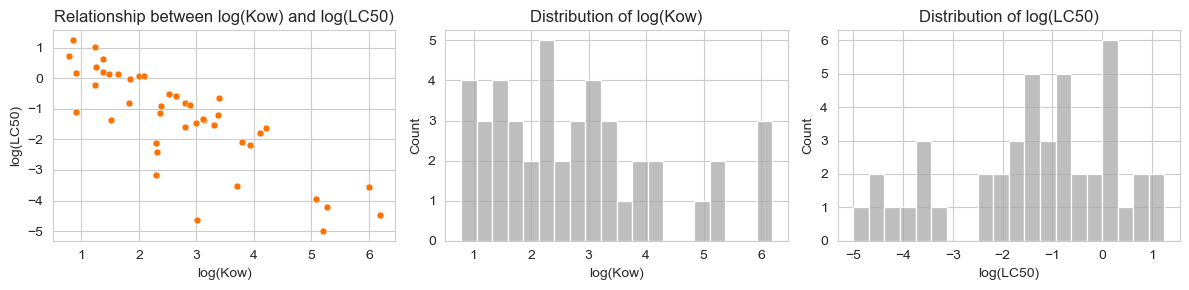

In [182]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Scatterplot
sns.scatterplot(data=toxicity, x='log_Kow', y='log_LC50', s=25, color='#fc7202', ax=axes[0])
axes[0].set_xlabel('log(Kow)')
axes[0].set_ylabel('log(LC50)')
axes[0].set_title('Relationship between log(Kow) and log(LC50)')

# Histograms
sns.histplot(toxicity['log_Kow'], bins=20, color='darkgray', ax=axes[1])
axes[1].set_xlabel('log(Kow)')
axes[1].set_title('Distribution of log(Kow)')

sns.histplot(toxicity['log_LC50'], bins=20, color='darkgray', ax=axes[2])
axes[2].set_xlabel('log(LC50)')
axes[2].set_title('Distribution of log(LC50)')

plt.tight_layout()
plt.show()

**Part C. Correlation analysis**

Compute:
- **Pearson’s r** and **R²**
    > Hint: since there is only one predictor, you can directly compute $R^2$ as $r^2$
- **Spearman’s ρ**

**Report** for each: the **direction** (positive/negative), the **strength** (small / moderate / strong), and the **p-value**.

In [187]:
# Pearson on log scale
x_lin = toxicity['log_Kow'].to_numpy()
y_lin = toxicity['log_LC50'].to_numpy()

pearson_r, pearson_p = stats.pearsonr(x_lin, y_lin)
R2 = pearson_r**2

# Spearman on original scale
x_rank = toxicity['Kow'].to_numpy()
y_rank = toxicity['LC50 (mmol/L)'].to_numpy()

spearman_rho, spearman_p = stats.spearmanr(x_rank, y_rank)

# Helper to label strength
def strength_label(v):
    a = abs(v)
    if a < 0.1: return "very weak"
    if a < 0.3: return "weak"
    if a < 0.5: return "moderate"
    if a < 0.7: return "moderately strong"
    if a < 0.9: return "strong"
    return "very strong"

dir_p = "positive" if pearson_r > 0 else "negative"
dir_s = "positive" if spearman_rho > 0 else "negative"

print(f"Pearson r (log-log) = {pearson_r:.3f} ({dir_p}, {strength_label(pearson_r)})  p = {pearson_p:.3g}")
print(f"R² (from Pearson)   = {R2:.3f}")
print(f"Spearman ρ (original) = {spearman_rho:.3f} ({dir_s}, {strength_label(spearman_rho)})  p = {spearman_p:.3g}")



Pearson r (log-log) = -0.818 (negative, strong)  p = 1.15e-11
R² (from Pearson)   = 0.670
Spearman ρ (original) = -0.814 (negative, strong)  p = 1.88e-11


> Pearson’s correlation on the log-log scale is **r = −0.818** (*p* = 1.15e−11), giving **R² = 0.670** - about **67%** of the variability in log₁₀(LC50) is explained by a linear relation with log₁₀(Kow).  
> Spearman’s rank correlation on the original scale is **ρ = −0.814** (*p* = 1.88e−11).  
>
> Both metrics agree on a **strong negative association**: more hydrophobic compounds (higher Kow) tend to have **lower LC50** (greater toxicity). The close match between **r** and **ρ** suggests the relationship is strongly **monotonic** and well-approximated as **linear** on the log scale.


**Part D. Fit a line and check hypotheses**

Now fit a **simple linear regression** on the **log-transformed** variables and evaluate the model.

**What to report (from the regression summary):**
- **Slope** and **intercept**
- ***t*-test for the slope** (`P>\|t\|`)
- **R²**
- **Overall *F*-test** of the model and its ***p*-value**

**Then check assumptions** using residual diagnostics:
- **Residuals vs fitted values** (look for randomness, no curvature/funnel)
- **Q-Q plot of residuals** (approximate normality)


                            OLS Regression Results                            
Dep. Variable:               log_LC50   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     85.22
Date:                Fri, 17 Oct 2025   Prob (F-statistic):           1.15e-11
Time:                        07:41:46   Log-Likelihood:                -58.703
No. Observations:                  44   AIC:                             121.4
Df Residuals:                      42   BIC:                             125.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1446      0.309      3.708      0.0

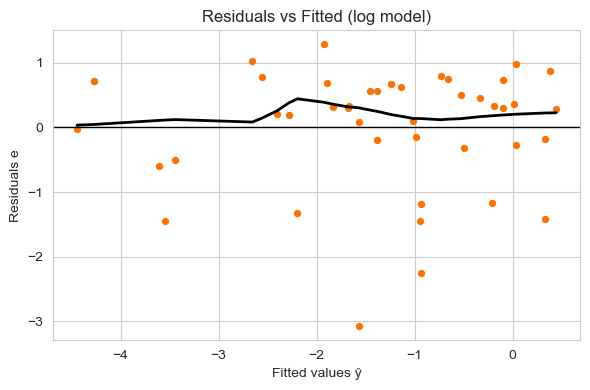

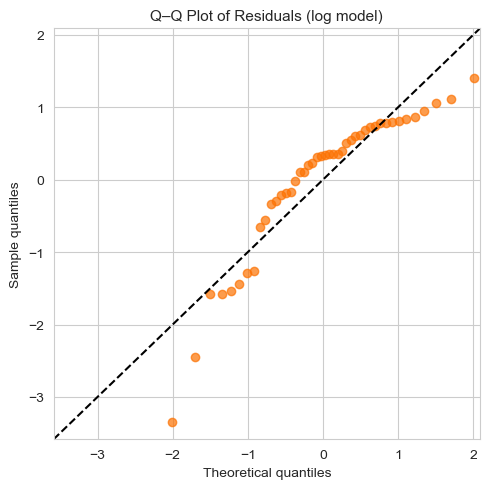

In [188]:
# Fit OLS on the log scale
lm = smf.ols('log_LC50 ~ log_Kow', data=toxicity).fit()
print(lm.summary())

# Pull key numbers
b0 = lm.params['Intercept']
b1 = lm.params['log_Kow']
p_slope = lm.pvalues['log_Kow']
r2 = lm.rsquared
F = lm.fvalue
p_F = lm.f_pvalue

print(f"\nEquation: ŷ = {b0:.4f} + {b1:.4f} · log10(Kow)")
print(f"Slope t-test P>|t| = {p_slope:.3g}")
print(f"R² = {r2:.3f}")
print(f"F-statistic = {F:.2f}, p = {p_F:.3g}")

# Residual diagnostics
fitted = lm.fittedvalues
resid = lm.resid

# 1) Residuals vs fitted with LOWESS
plt.figure(figsize=(6,4))
plt.scatter(fitted, resid, s=18, color='#fc7202')
plt.axhline(0, color='black', lw=1)
lowess = sm.nonparametric.lowess(resid, fitted, frac=0.6)
plt.plot(lowess[:,0], lowess[:,1], color='black', lw=2)
plt.xlabel('Fitted values ŷ')
plt.ylabel('Residuals e')
plt.title('Residuals vs Fitted (log model)')
plt.tight_layout()
plt.show()

# 2) Q–Q plot of residuals
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
sm.qqplot(resid, line='45', fit=True, ax=ax,
          markerfacecolor='#fc7202', markeredgecolor='#fc7202', alpha=0.7)
ax.get_lines()[1].set_color('black')
ax.get_lines()[1].set_linestyle('--')
ax.set_title('Q–Q Plot of Residuals (log model)', fontsize=11)
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Sample quantiles')
plt.tight_layout()
plt.show()